# Text Generation With LSTM Recurrent Neural Networks in Python with Keras

## Рекурентні нейронні мережі також можуть використовуватися як генеративні моделі. Це означає, що як додаток до того, що вони використовуються для прогнозних моделей (передбачень), вони можуть вивчати послідовності проблеми, а потім генерувати абсолютно нові правдоподібні послідовності для проблемної області. Такі генеративні моделі корисні не тільки для вивчення того, наскільки добре модель засвоїла проблему, а й для того, щоб дізнатися більше про саму проблему. На даній презентації ви дізнаєтеся, як створити генеративну модель для тексту, символ за символом, використовуючи рекурентні нейронні мережі LSTM в Python з Keras.



### Для перевірки роботи алгоритму була використмана всіми улюблена казка "Пригоди Аліси в країні чудес"

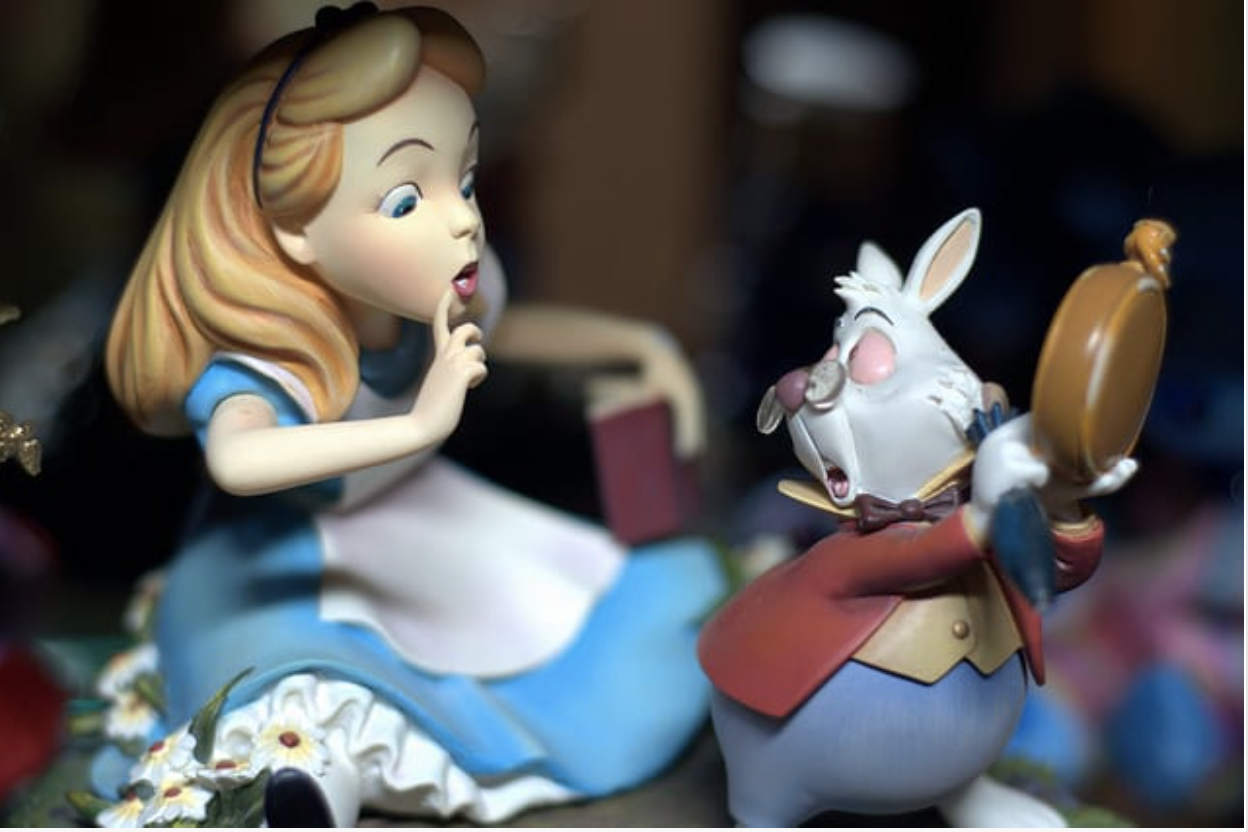

In [3]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [4]:
# load ascii text and covert to lowercase
filename = "wonderland.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

In [5]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [6]:
n_chars = len(raw_text)
n_vocab = len(chars)
print ("Total Characters: ", n_chars)
print ("Total Vocab: ", n_vocab)

Total Characters:  144519
Total Vocab:  45


### Ми бачимо, що книга містить трохи менше 150 000 символів, і що при перетворенні на нижній регістр у словнику є лише 45 окремих символів, які мережа може вивчити. Набагато більше, ніж 26 в алфавіті. Тепер нам потрібно визначити навчальні дані для мережі. Існує велика гнучкість у тому, як ви вирішите розділити текст для навчання. У цьому випадку ми розділимо текст книги на підпослідовності з фіксованою довжиною 100 символів, довільною довжиною. Ми могли б так само легко розділити дані на речення, додати коротші послідовності та обрізати довші. Кожен навчальний шаблон мережі складається із 100 кроків по одному символу (X), за яким слід вивести один символ (y). Створюючи ці послідовності, ми пересуваємо цей блок по всій книзі по одному символу за раз, надаючи кожному символу можливість вивчити 100 символів, які передували йому (крім перших 100 символів, звичайно).

In [7]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print ("Total Patterns: ", n_patterns)

Total Patterns:  144419


### Коли ми розбиваємо книгу на ці послідовності, ми перетворюємо символи в числа, використовуючи нашу таблицю пошуку, яку ми підготували раніше.

### Тепер, коли ми підготували наші навчальні дані, нам потрібно трансформувати їх, щоб вони придатні для використання з Keras. Спочатку ми повинні перетворити список вхідних послідовностей у форму [samples, time steps, features], яку очікує мережа LSTM. 

### Далі нам потрібно змінити масштаб цілих чисел до діапазону від 0 до 1, щоб зробити шаблони легшим для вивчення мережею LSTM, яка за замовчуванням використовує сигмовидну функцію активації.

### Нарешті, нам потрібно перетворити вихідні шаблони (окремі символи, перетворені на цілі числа) в одне гаряче кодування(hot coding). Це робиться для того, щоб ми могли налаштувати мережу для прогнозування ймовірності кожного з 47 різних символів у словнику, а не намагатися змусити її передбачити саме наступний символ. Кожне значення Y перетворюється на розріджений вектор довжиною 47, наповнений нулями, за винятком 1 в стовпці для літери (цілого числа), яку представляє шаблон.

In [8]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

### Тепер ми можемо визначити нашу модель LSTM. Тут ми визначаємо один прихований шар LSTM з 256 одиницями пам’яті. Мережа використовує dropout з імовірністю 20. Вихідний рівень є щільним шаром, який використовує функцію активації softmax для виведення прогнозу ймовірності для кожного з 47 символів від 0 до 1. Aлгоритм оптимізації ADAM.

In [9]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [19]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [20]:
model.fit(X, y, epochs=5, batch_size=128, callbacks=callbacks_list)

Epoch 1/5
1129/1129 [==============================] - 247s 219ms/step - loss: 2.7684

Epoch 00001: loss improved from inf to 2.76842, saving model to weights-improvement-01-2.7684.hdf5
Epoch 2/5
1129/1129 [==============================] - 242s 214ms/step - loss: 2.6727

Epoch 00002: loss improved from 2.76842 to 2.67273, saving model to weights-improvement-02-2.6727.hdf5
Epoch 3/5
1129/1129 [==============================] - 285s 253ms/step - loss: 2.5919

Epoch 00003: loss improved from 2.67273 to 2.59186, saving model to weights-improvement-03-2.5919.hdf5
Epoch 4/5
1129/1129 [==============================] - 277s 245ms/step - loss: 2.5240

Epoch 00004: loss improved from 2.59186 to 2.52400, saving model to weights-improvement-04-2.5240.hdf5
Epoch 5/5
1129/1129 [==============================] - 291s 258ms/step - loss: 2.4640

Epoch 00005: loss improved from 2.52400 to 2.46396, saving model to weights-improvement-05-2.4640.hdf5


### Особливість. Набору тестових даних немає. Ми моделюємо весь навчальний набір даних, щоб дізнатися ймовірність кожного символу в послідовності. Нас не цікавить точність класифікації моделі навчального набору даних. Це була б модель, яка ідеально прогнозує появу кожного символу в наборі навчальних даних. Замість цього нас цікавить узагальнення набору даних, яке мінімізує обрану функцію втрат. 

In [21]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [22]:
 import sys

In [23]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print ("\nDone.")

Seed:
" 
wish i'd gone to see the hatter instead!'




chapter vii. a mad tea-party

there was a table set o "
o toe to toe to toe to toe to toe to the toeee  

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### Згенерований текст при 20 епохах

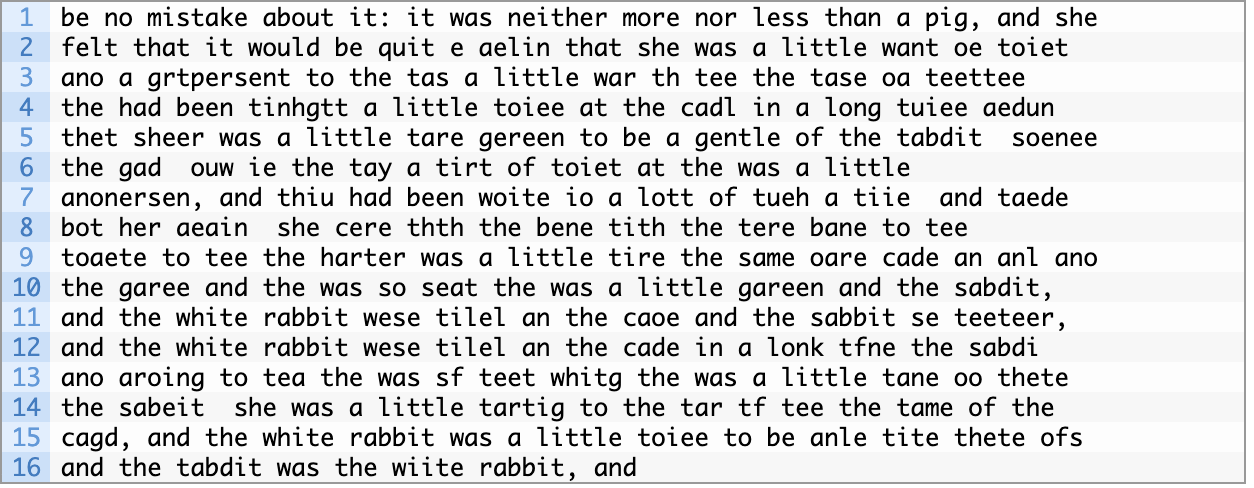

### Можна відзначити деякі спостереження щодо згенерованого тексту.

### Він відповідає формату рядка, який спостерігається в оригінальному тексті, що містить менше 80 символів перед новим рядком.
### Символи розділені на групи, схожі на слова, і більшість груп є справжніми англійськими словами (наприклад, «the», «little» і «was»), але багато які ні (наприклад, «lott», «tiie» і «taede»).
### Деякі слова в послідовності мають сенс (наприклад, «і білий кролик»), але багато ні (наприклад, «wese tilel»).
### Той факт, що ця модель книги, заснована на персонажах, видає подібні результати, дуже вражає. Це дає вам відчуття можливостей навчання мереж LSTM.

### Результати не ідеальні. У наступному розділі ми спробуємо розглянути покращення якості результатів шляхом розробки значно більшої мережі LSTM.

In [33]:
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the LSTM model



In [37]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [38]:

# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [39]:
# fit the model
model.fit(X, y, epochs=5, batch_size=64, callbacks=callbacks_list)

Epoch 1/5
2257/2257 [==============================] - 848s 375ms/step - loss: 2.7761

Epoch 00001: loss improved from inf to 2.77606, saving model to weights-improvement-01-2.7761-bigger.hdf5
Epoch 2/5
2257/2257 [==============================] - 941s 417ms/step - loss: 2.3971

Epoch 00002: loss improved from 2.77606 to 2.39707, saving model to weights-improvement-02-2.3971-bigger.hdf5
Epoch 3/5
2257/2257 [==============================] - 991s 439ms/step - loss: 2.1929

Epoch 00003: loss improved from 2.39707 to 2.19293, saving model to weights-improvement-03-2.1929-bigger.hdf5
Epoch 4/5
2257/2257 [==============================] - 908s 402ms/step - loss: 2.0606

Epoch 00004: loss improved from 2.19293 to 2.06063, saving model to weights-improvement-04-2.0606-bigger.hdf5
Epoch 5/5
2257/2257 [==============================] - 1127s 500ms/step - loss: 1.9658

Epoch 00005: loss improved from 2.06063 to 1.96577, saving model to weights-improvement-05-1.9658-bigger.hdf5


In [40]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print ("\nDone.")

Seed:
" s folded, quietly smoking a long
hookah, and taking not the smallest notice of her or of anything el "
r a little sooe the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the thmeer the 

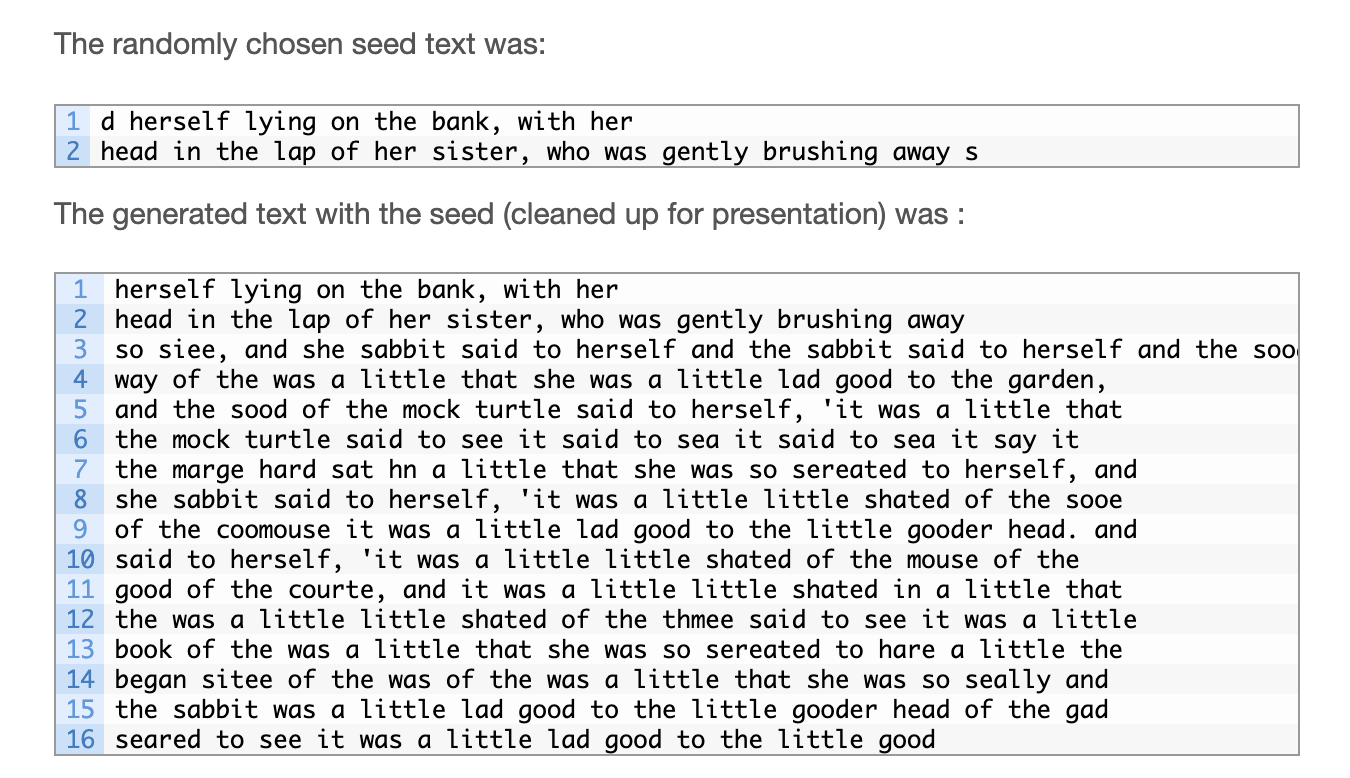

### Ми бачимо, що загалом орфографічних помилок менше, а текст виглядає більш реалістичним, але все ще досить безглуздий. Наприклад, одні й ті ж фрази повторюються знову і знову, наприклад «said to herself» і «little». Це кращі результати, але є ще багато можливостей для покращення.

## Висновок

### Ми дослідили генерацію тексту в мережах LSTM та отримали задовільні результати.